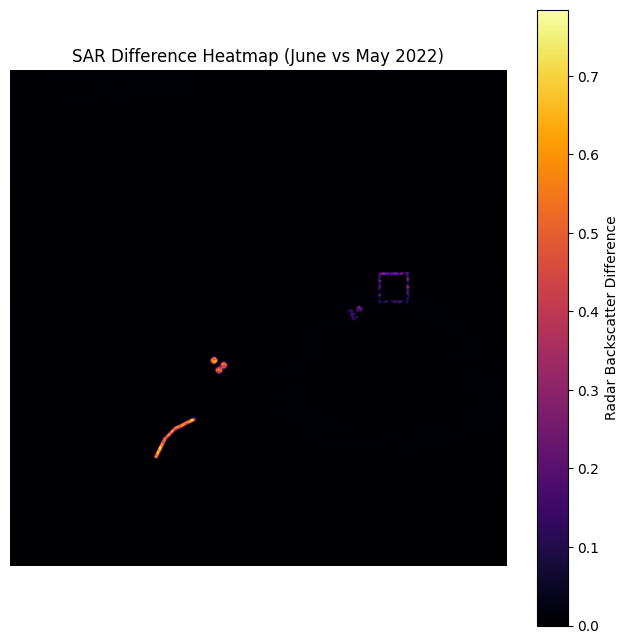

[+] SAR overlay saved.


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from PIL import Image, ImageDraw
import os
import cv2
from PIL import ImageFont


# === STEP 1: Load SAR Images ===
may_path = "../data/satellite_images/solonytsivka_may2022_sar.png"
jun_path = "../data/satellite_images/solonytsivka_jun2022_sar.png"

with rasterio.open(may_path) as src:
    sar_may = src.read(1)
with rasterio.open(jun_path) as src:
    sar_jun = src.read(1)

# === STEP 2: Normalize & Smooth ===
def normalize(img):
    img = np.clip(img, np.percentile(img, 5), np.percentile(img, 95))
    return (img - img.min()) / (img.max() - img.min())

sar_may_norm = normalize(gaussian_filter(sar_may, sigma=1))
sar_jun_norm = normalize(gaussian_filter(sar_jun, sigma=1))

# === STEP 3: Compute Difference ===
sar_diff = np.abs(sar_jun_norm - sar_may_norm)

# === STEP 4: Generate Color Heatmap as Overlay ===
sar_diff_norm = (sar_diff * 255).astype(np.uint8)
heatmap = cv2.applyColorMap(sar_diff_norm, cv2.COLORMAP_INFERNO)

plt.figure(figsize=(8, 8))
plt.imshow(sar_diff, cmap='inferno')
plt.title("SAR Difference Heatmap (June vs May 2022)")
plt.axis('off')
plt.colorbar(label="Radar Backscatter Difference")
plt.savefig("../data/output/change_maps/sar_diff_heatmap.png", bbox_inches='tight')
plt.show()

# === STEP 4B: Load Base Image for Context ===
base_img_path = "../data/satellite_images/solonytsivka_jun2022_falsecolorurban.png"
base_img = cv2.imread(base_img_path)
base_img = cv2.resize(base_img, (heatmap.shape[1], heatmap.shape[0]))

# === STEP 4C: Blend Heatmap Over Real Image ===
blended = cv2.addWeighted(base_img, 0.7, heatmap, 0.6, 0)


# === STEP 5: Annotate Top Change Regions ===
threshold = 0.2
mask = (sar_diff > threshold).astype(np.uint8)
from scipy.ndimage import label, find_objects

labeled, n = label(mask)
regions = find_objects(labeled)

# Convert to Image overlay
overlay = Image.fromarray((sar_jun_norm * 255).astype(np.uint8)).convert("RGBA")
draw = ImageDraw.Draw(overlay)

annotations = []
for i, reg in enumerate(regions):
    y1, y2 = reg[0].start, reg[0].stop
    x1, x2 = reg[1].start, reg[1].stop
    area = (x2 - x1) * (y2 - y1)
    if area < 150: continue
    draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
    draw.text((x1, y1-10), f"SAR Change {i+1}", fill="red")
    annotations.append({
        "label": f"SAR Change {i+1}",
        "x1": x1, "y1": y1, "x2": x2, "y2": y2, "area": area
    })

overlay.save("../data/output/change_maps/sar_overlay.png")
print("[+] SAR overlay saved.")

# === STEP 6: Intelligence Report ===
with open("../reports/sar_intelligence_report.md", "w") as f:
    f.write("# SAR-Based Intelligence Report – Solonytsivka, Ukraine\n\n")
    f.write("## Summary\nRadar backscatter comparison (Sentinel‑1 VV) between May and June 2022 reveals surface changes possibly indicating:\n\n")
    f.write("- Track marks from vehicle movement\n")
    f.write("- Construction or demolition\n")
    f.write("- Burned or disturbed ground\n\n")
    f.write("## Detected Changes\n")
    for a in sorted(annotations, key=lambda x: -x['area'])[:5]:
        f.write(f"- **{a['label']}** — Coords: ({a['x1']},{a['y1']})–({a['x2']},{a['y2']}), Area: {a['area']} px\n")
    f.write("\n---\nGenerated via `sar_analysis_change_detect.ipynb`.\n")
